In [1]:
from pathlib import Path
import meshio
from mesh_handler import xdmf_to_meshes, meshes_to_xdmf, vtu_to_mesh, mesh_to_vtu,  accessing_mesh_data, create_mock_mesh
from preprocessing_utils import *
import torch
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
import random
from DL_utils import *




Ces modifications permettent d'utiliser le GPU MPS pour les opérations de tenseur et le modèle si le GPU MPS est disponible.

Les modifications ont été apportées.

In [2]:
import torch
from pathlib import Path

# Vérifier si MPS est disponible, sinon utiliser le CPU
device = torch.device("cpu")

# Example use

# Après l'exécution de preprocessing_utils.py avec 4Students_AnXplore03 dans le même répertoire,
# un dossier nommé "data_cleaned" sera créé avec les fichiers de maillage prétraités.
# La fonction get_X_y peut être utilisée pour obtenir les données d'entrée et de sortie de mesh_id.
features_method = get_X_y_acc_type

# Récupérer la liste de tous les mesh_ids
CWD = Path.cwd()
data_path = CWD / "data_cleaned"
xdmf_files = list(data_path.glob("*.pth"))
mesh_ids = [xdmf_file.name.split("_")[1].split(".")[0] for xdmf_file in xdmf_files]
mesh_id = mesh_ids[0]

# Charger les données en les transférant vers le GPU MPS
X_nodes, X_edges, y = features_method(mesh_id, time_step=1)

# Déplacement des tenseurs vers le GPU Apple (MPS) si disponible
X_nodes = torch.tensor(X_nodes).to(device)
X_edges = torch.tensor(X_edges).to(device)
y = torch.tensor(y).to(device)

nb_features = X_nodes.shape[1]      

print("Shape des X_nodes :", X_nodes.shape)
print("Shape des X_edges :", X_edges.shape)
print("Shape de y :", y.shape)
print("Nombre de features :", nb_features)


Shape des X_nodes : torch.Size([12567, 12])
Shape des X_edges : torch.Size([2, 79366])
Shape de y : torch.Size([12567, 4])
Nombre de features : 12


/Users/leonard/Desktop/MINES/3A/IDSC/DC_flood/preprocessing_utils.py:92: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  data = torch.load(data_dir / f"mesh_{mesh_id}.pth")
/v

In [3]:
import numpy as np
from torch.utils.data import DataLoader

def compute_mesh_statistics(mesh_id, features_method):
    total_sum = 0
    total_sum_of_squares = 0
    total_count = 0

    for time_step in range(79):  # 79 time steps par mesh_id
        X_nodes, X_edges, y = features_method(mesh_id, time_step)
        X_nodes = X_nodes.numpy()
        total_sum += np.sum(X_nodes, axis=0)
        total_sum_of_squares += np.sum(X_nodes ** 2, axis=0)
        total_count += X_nodes.shape[0]

    mean = total_sum / total_count
    variance = (total_sum_of_squares / total_count) - (mean ** 2)
    std = np.sqrt(variance)

    return mean, std

# Exemple d'utilisation
mesh_id = mesh_ids[0]  # Utiliser le premier mesh_id pour l'exemple
mean, std = compute_mesh_statistics(mesh_id, features_method)

## data explo

In [ ]:
from torch.utils.data import Dataset, DataLoader

In [ ]:
import torch
import torch.nn.functional as F
from torch_geometric.nn import GCNConv, LayerNorm
class CFDGNN(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels):
        super(CFDGNN, self).__init__()
        
        # Convolution layers
        self.conv1 = GCNConv(in_channels, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, hidden_channels)
        self.conv3 = GCNConv(hidden_channels, hidden_channels)
        
        # MLP after normalization
        self.mlp = torch.nn.Sequential(
            torch.nn.Linear(in_channels, 64),  # Example dimension, modify as needed
            torch.nn.ReLU(),
            torch.nn.Linear(64, in_channels)
        )
        self.LayerNorm = LayerNorm(hidden_channels)
        # Output layer
        self.lin = torch.nn.Linear(hidden_channels, out_channels)
        
        # Normalization parameters (assuming mean and std are defined elsewhere)
        self.mean = torch.tensor(mean, dtype=torch.float32)
        self.std = torch.tensor(std, dtype=torch.float32)

    def forward(self, x, edge_index, edge_weights=None):
        x_src = x
        # Normalization step
        x = (x - self.mean) / self.std
        
        # MLP after normalization
        # x = self.mlp(x)
        
        # Graph convolutions
        x = self.conv1(x, edge_index, edge_weights)
        x = F.relu(x)
        x = self.LayerNorm(x)
        x = self.conv2(x, edge_index, edge_weights)
        x = F.relu(x)
        x = self.LayerNorm(x)

        x = self.conv3(x, edge_index, edge_weights)
        x = F.relu(x)
        x = self.LayerNorm(x)

        # Final output layer
        x = self.lin(x)
        
        return  x + x_src[:,:, 3:7]  # Skip connection


In [ ]:
from DL_utils import train_test_sets
epoch = 4
# Initialisation du modèle et de l'optimiseur
model = CFDGNN(in_channels=nb_features, hidden_channels=32, out_channels=4)
# model = GraphUNetModel(in_channels=nb_features, hidden_channels=16, out_channels=4)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

# Split des données en ensembles d'entraînement et de test
train_mesh_ids, test_mesh_ids = train_test_sets(mesh_ids, test_size=0.2, random_state=42)

# # Entraînement du modèle
train_loss = train_model(model, optimizer, train_mesh_ids, epochs=epoch, batch_size=1, features_method=features_method, device=device)

# # Évaluation du modèle

average_loss = evaluate_model(model, test_mesh_ids, features_method=features_method, device=device)

print(f'Average Test Loss: {average_loss:.4f}')

Epoch 4/4: 100%|██████████| 6557/6557 [11:18<00:00,  9.66batch/s, loss=182]    


Average Test Loss: 150.7335


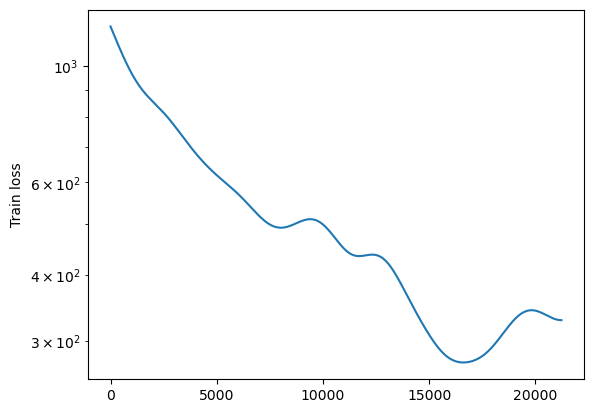

In [60]:
from scipy.ndimage import gaussian_filter1d
train_loss = gaussian_filter1d(train_loss, sigma=500)
plt.plot(train_loss[5000:])
plt.ylabel("Train loss")

plt.yscale('log')

In [ ]:
checkpoint = {
    'model_state_dict': model.state_dict(),
    'optimizer_state_dict': optimizer.state_dict(),
    'train_loss': train_loss,
    'epoch' : epoch}

torch.save(checkpoint, './models/network_1_e4.pth')
print("Modèle et optimiseur sauvegardés avec succès.")

Modèle et optimiseur sauvegardés avec succès.


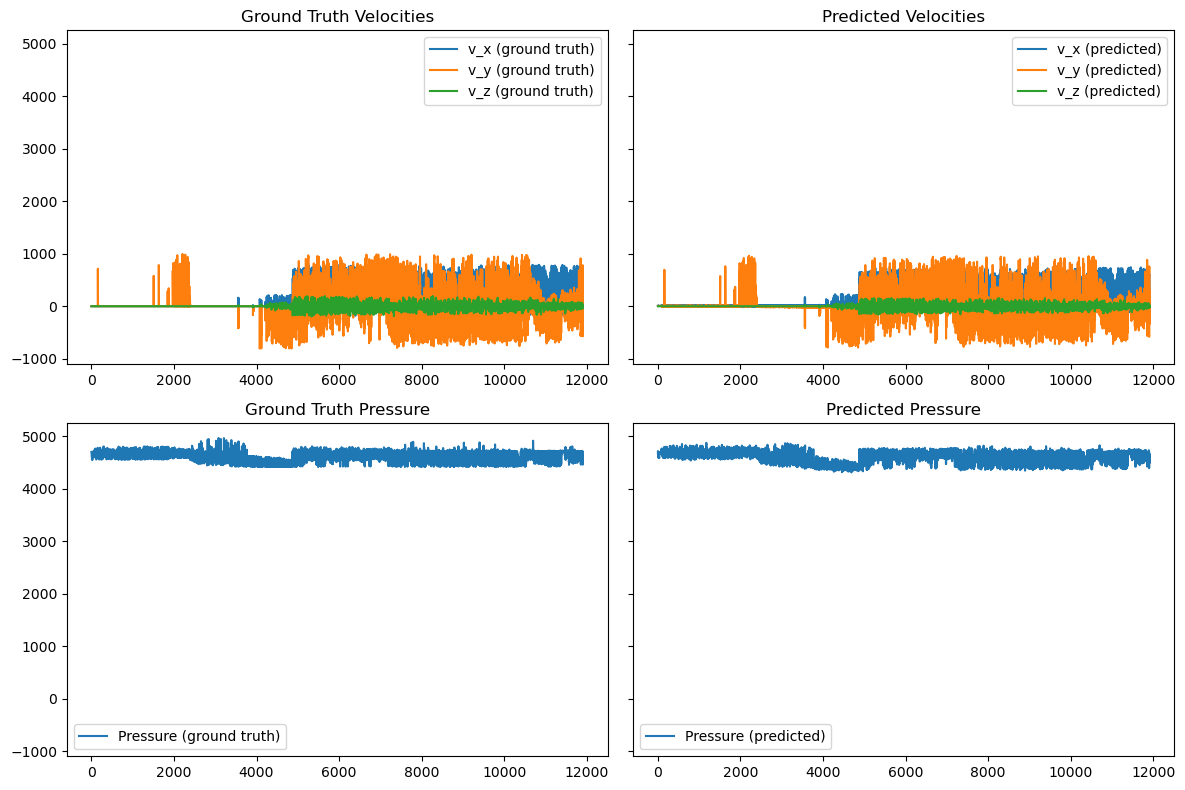

In [85]:
import random

import matplotlib.pyplot as plt

def visualize_prediction(model, mesh_id, time_step):
    X_nodes, X_edges, y = features_method(mesh_id, time_step=time_step)
    edge_weights = compute_edge_weights(X_edges, X_nodes)
    
    model.eval()
    with torch.no_grad():
        y_pred = model(X_nodes.unsqueeze(0), X_edges, edge_weights).squeeze(0)
    fig, axs = plt.subplots(2, 2, figsize=(12, 8), sharey=True)
    
    # Ground truth velocities
    axs[0, 0].plot(y[:, 0], label='v_x (ground truth)')
    axs[0, 0].plot(y[:, 1], label='v_y (ground truth)')
    axs[0, 0].plot(y[:, 2], label='v_z (ground truth)')
    axs[0, 0].set_title('Ground Truth Velocities')
    axs[0, 0].legend()
    
    # Predicted velocities
    axs[0, 1].plot(y_pred[:, 0], label='v_x (predicted)')
    axs[0, 1].plot(y_pred[:, 1], label='v_y (predicted)')
    axs[0, 1].plot(y_pred[:, 2], label='v_z (predicted)')
    axs[0, 1].set_title('Predicted Velocities')
    axs[0, 1].legend()
    
    # Ground truth pressure
    axs[1, 0].plot(y[:, 3], label='Pressure (ground truth)')
    axs[1, 0].set_title('Ground Truth Pressure')
    axs[1, 0].legend()
    
    # Predicted pressure
    axs[1, 1].plot(y_pred[:, 3], label='Pressure (predicted)')
    axs[1, 1].set_title('Predicted Pressure')
    axs[1, 1].legend()
    
    plt.tight_layout()
    plt.show()
    return y_pred
mesh_id = mesh_ids[5]
time_step =  5
y_pred =visualize_prediction(model, mesh_id, time_step)

In [76]:
y_pred

tensor([[[ 6.7172e+00,  4.0890e-01,  1.4606e-02,  4.9118e+02],
         [ 7.0824e+00,  2.4789e+00,  8.6301e-03,  5.5546e+02],
         [ 3.0681e+00, -2.7843e+00,  3.3786e-02,  4.9961e+02],
         ...,
         [ 3.2288e+02, -1.0361e+02,  1.7448e+01,  5.9399e+02],
         [ 1.2550e+01,  1.0873e+01,  1.1315e+01,  5.8583e+02],
         [ 3.1123e+02, -1.0109e+02, -7.4678e+00,  6.2093e+02]]])

In [ ]:


def save_difference_to_vtu(model, mesh_id, time_step, output_file):
    X_nodes, X_edges, y = features_method(mesh_id, time_step=time_step)
    edge_weights = compute_edge_weights(X_edges, X_nodes)
    
    model.eval()
    with torch.no_grad():
        y_pred = model(X_nodes, X_edges, edge_weights)
    
    # Calculate differences
    diff = (y - y_pred)**2
    
    # Create meshio mesh
    points = X_nodes[:, :3].numpy()
    cells = [("line", X_edges.T.numpy())]
    point_data = {
        "v_x_diff": diff[:, 0].numpy(),
        "v_y_diff": diff[:, 1].numpy(),
        "v_z_diff": diff[:, 2].numpy(),
        "pressure_diff": diff[:, 3].numpy()
    }
    
    mesh = meshio.Mesh(points, cells, point_data=point_data)
    mesh.write(output_file)

# Exemple d'utilisation
mesh_id = mesh_ids[0]
time_step = 2
output_file = f"./vtus/MSE_{mesh_id}_t_{time_step}.vtu"
save_difference_to_vtu(model, mesh_id, time_step, output_file)



Les modifications ont été apportées.